# Machine Learning Applications for Predicting Renewable Energy Project Success in the PJM Interconnection Queue
Natalie Avida

Honors Thesis, Environmental Science B.S.

University of California, Berkeley

Spring 2024

## 0. Packages

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## 1. Data Merges & Cleaning
### Data Uploads

In [3]:
# LBNL's "Queued Up" Dataset
lbnl_queues_data = pd.read_csv('/home/jovyan/THESIS/data/LBNL_queues_2023.csv', low_memory=False)

# Selecting only PJM Projects
lbnl_PJM_queues = lbnl_queues_data[lbnl_queues_data['entity']=='PJM']

In [3]:
# LBNL's PJM Cost of Interconnection Dataset
lbnl_PJM_costs = pd.read_csv('/home/jovyan/THESIS/data/lbnl_pjm_costs_2022.csv')

In [4]:
# PJM's data with cleaned target variable
pjm_data_w_tv = pd.read_csv('/home/jovyan/THESIS/data/pjm_PlanningQueues_JoeTV.csv')

In [5]:
# Policy feature datasets
policy_utilities = pd.read_csv('/home/jovyan/THESIS/data/policyfeatures_utilities.csv')
policy_states = pd.read_csv('/home/jovyan/THESIS/data/policyfeatures_states.csv')

In [6]:
# Lat Long coordinates, courtesy of LBNL
pjm_lat_lons = pd.read_csv('/home/jovyan/THESIS/data/PJM_queue_lat_longs_Apr2023.csv')

### Data Cleaning & Removal of Unnecessary Columns for queue_basic and queue_costs

In [7]:
# Creating a new interconnection column with only three options--in progress, withdrawn, and executed
pjm_data_w_tv['IA_Status_Clean'] = pjm_data_w_tv['Status']
pjm_data_w_tv['IA_Status_Clean'].replace({
    'Active': 'In Progress',
    'Annulled': 'Withdrawn',
    'Canceled': 'Withdrawn',
    'Confirmed': 'In Progress',
    'Deactivated': 'Withdrawn',
    'Engineering and Procurement': 'In Progress',
    'In Service': 'Executed',
    'Partially in Service - Under Construction': 'Executed',
    'Retracted': 'Withdrawn',
    'Suspended': 'In Progress',
    'Under Construction': 'Executed',
    'Withdrawn': 'Withdrawn'
}, inplace=True)

# Ensuring all projects with a withdrawal date are marked as withdrawn
condition_1 = pjm_data_w_tv['Withdrawal Date'].notna()
pjm_data_w_tv.loc[condition_1, 'IA_Status_Clean'] = 'Withdrawn'

In [8]:
# Selecting columns to creating queue_basic
queue_basic = pjm_data_w_tv[['Project ID','State', 'County', 'Transmission Owner', 'MFO', 'MW_clean', 'MW Capacity',
                          'MW In Service', 'Capacity or Energy', 'Project Type', 'Submitted Date', 'IA_Status_Clean']]

In [9]:
# Clean column names to help merge
# Dropping Unknown counties because there are only 88
queue_basic = queue_basic[queue_basic['County'] != 'Unknown']

# merging in utility and state policy data
queue_basic = queue_basic.merge(policy_utilities, how='left',left_on='Transmission Owner', right_on='Utility')
queue_basic = queue_basic.drop(columns={'Utility'})

queue_basic = queue_basic.merge(policy_states, how='left',on='State')

# merging in lat and lon values for solar and wind features, which will be made in 2.
pjm_lat_lons = pjm_lat_lons[['Column1.attributes.QUEUE_ID','Column1.geometry.x','Column1.geometry.y']]
pjm_lat_lons = pjm_lat_lons.rename(columns={'Column1.attributes.QUEUE_ID':'Project ID',
                                           'Column1.geometry.x':'Longitude',
                                           'Column1.geometry.y':'Latitude'})

queue_basic = queue_basic.merge(pjm_lat_lons, how='left',on='Project ID')

# Merge with the PJM_queues dataset because it has already cleaned different types of energy out
selected_lbnl_queues = lbnl_PJM_queues[['q_id','q_year','region','prop_year','prop_date', 'type_clean']]
queue_basic = queue_basic.merge(selected_lbnl_queues, how='inner', left_on='Project ID', right_on='q_id').drop(columns={'q_id'})

In [10]:
# Merging queue_basic with the LBNL costs dataset to create queue_costs
selected_lbnl_costs = lbnl_PJM_costs[['Project #','$2022 POI Cost/kW','$2022 Network Cost/kW', '$2022 Total Cost/kW']]
queue_costs = queue_basic.merge(selected_lbnl_costs, how='inner', left_on='Project ID', right_on='Project #').drop(columns={'Project #'})

In [11]:
# Getting rid of all "in progress" projects to ensure only that only the 0 and 1 remain
queue_basic = queue_basic[queue_basic['IA_Status_Clean']!='In Progress']
queue_costs = queue_costs[queue_costs['IA_Status_Clean']!='In Progress']

### Creating Renewable Resource Columns

In [12]:
# Importing counties df
# Created by geopandas in a different Jupyter notebook--requires lots of computational power
counties_df = pd.read_csv('/home/jovyan/THESIS/data/counties_centroids.csv')
counties_df = counties_df.rename(columns={'STATE':'State','COUNTYNAME':'County',
                                          'latitude':'County Latitude','longitude':'County Longitude'})

In [13]:
# Importing solar data
solar_df = pd.read_csv('/home/jovyan/THESIS/data/NREL_PV_data.csv')
solar_df = solar_df.rename(columns={'latitude':'Latitude','longitude':'Longitude'})

In [14]:
# Importing wind data
wind_df = pd.read_csv('/home/jovyan/THESIS/data/NREL_wind_data.csv')
wind_df = wind_df.rename(columns={'latitude':'Latitude','longitude':'Longitude'})

In [15]:
# Merging in counties dataframe lat lon to queue_basic
queue_basic = queue_basic.merge(counties_df, how='left', on=['State','County'])

# filling in the empty lat and lon columns with the column values
queue_basic['Latitude'] = queue_basic['Latitude'].fillna(queue_basic['County Latitude'])
queue_basic['Longitude'] = queue_basic['Longitude'].fillna(queue_basic['County Longitude'])

# dropping NaN values
queue_basic = queue_basic[queue_basic['Latitude'].isna() != True]

# dropping county columns
queue_basic = queue_basic.drop(columns={'County Latitude','County Longitude'})

In [16]:
# merging in counties dataframe lat lon to queue_costs
queue_costs = queue_costs.merge(counties_df, how='left', on=['State','County'])

# filling in the empty lat and lon columns with the column values
queue_costs['Latitude'] = queue_costs['Latitude'].fillna(queue_costs['County Latitude'])
queue_costs['Longitude'] = queue_costs['Longitude'].fillna(queue_costs['County Longitude'])

# dropping NaN values
print(len(queue_costs[queue_costs['Latitude'].isna() == True]))
queue_costs = queue_costs[queue_costs['Latitude'].isna() != True]

# dropping county columns
queue_costs = queue_costs.drop(columns={'County Latitude','County Longitude'})

0


In [17]:
# Initiating the Nearest Neighbor Search with solar & wind values

from scipy.spatial import cKDTree

def add_nearest_solar_data(target_df, solar_df):
    # Convert target and solar data points to numpy arrays for spatial indexing
    target_points = target_df[['Latitude', 'Longitude']].to_numpy()
    solar_points = solar_df[['Latitude', 'Longitude']].to_numpy()

    # Create a spatial index for the solar points
    tree = cKDTree(solar_points)

    # Query the tree for the nearest solar point to each target point
    distances, indices = tree.query(target_points)

    # Add the nearest solar data into the target DataFrame
    target_df['NearestSolarDistance'] = distances
    target_df['NearestSolarCapacityFactor'] = solar_df.iloc[indices]['capacity_factor'].values
    target_df['NearestIrradiance'] = solar_df.iloc[indices]['global_horizontal_irradiance'].values
    target_df['NearestDistancetoTransmission'] = solar_df.iloc[indices]['distance_to_transmission_km'].values

    return target_df

def add_nearest_wind_data(target_df, wind_df):
    # Convert target and wind data points to numpy arrays for spatial indexing
    target_points = target_df[['Latitude', 'Longitude']].to_numpy()
    wind_points = wind_df[['Latitude', 'Longitude']].to_numpy()

    # Create a spatial index for the ind points
    tree = cKDTree(wind_points)

    # Query the tree for the nearest wind point to each target point
    distances, indices = tree.query(target_points)

    # Add the nearest wind data into the target DataFrame
    target_df['NearestWindDistance'] = distances
    target_df['NearestWindCapacityFactor'] = wind_df.iloc[indices]['capacity_factor'].values
    target_df['NearestWindSpeed'] = wind_df.iloc[indices]['wind_speed'].values

    return target_df

# Apply the function to second_df and third_df
queue_basic = add_nearest_solar_data(queue_basic, solar_df)
queue_basic = add_nearest_wind_data(queue_basic, wind_df)

queue_costs = add_nearest_solar_data(queue_costs, solar_df)
queue_costs = add_nearest_wind_data(queue_costs, wind_df)

In [18]:
# Downloading the datasets to have prior to One Hot Encoding & Feature Engineering
queue_basic.to_csv('queue_basic.csv', index=False)
queue_costs.to_csv('queue_costs.csv', index=False)

## 2. One Hot Encoding
#### queue_basic

In [19]:
queue_basic_ohe = queue_basic[['State', 'County', 'Transmission Owner',
                           'Capacity or Energy','type_clean','IA_Status_Clean']]

In [20]:
# Fitting the OneHotEncoder
enc_basic = OneHotEncoder(handle_unknown='ignore')
enc_basic.fit(queue_basic_ohe)

# Transform the second_df using the encoder
ohe_basic_array = enc_basic.transform(queue_basic_ohe).toarray()  # Convert to dense format

# Get the names of the new one-hot encoded features
feature_names = enc_basic.get_feature_names_out(input_features=queue_basic_ohe.columns)

# Create a new DataFrame from the one-hot encoded array and the feature names
ohe_basic_df = pd.DataFrame(ohe_basic_array, columns=feature_names)

In [21]:
# Select only numerical columns
queue_basic_numerical = queue_basic[['MFO','MW_clean',
       'Utility_100_RE_CE', 'Utility_NetNegative',
       'Utility_NetZero_CarbonNeutral', 'Utility_PartialReduction',
       'State_100_RE_CE_Std','Longitude', 'Latitude', 'q_year','NearestSolarDistance', 
        'NearestSolarCapacityFactor', 'NearestIrradiance','NearestDistancetoTransmission',
         'NearestWindDistance', 'NearestWindCapacityFactor', 'NearestWindSpeed']]

In [22]:
# Reset indices of both DataFrames to ensure they are aligned by row order--this should still be fine right?
ohe_basic_df_reset = ohe_basic_df.reset_index(drop=True)
basic_df_numerical_reset = queue_basic_numerical.reset_index(drop=True)

# Concatenate after resetting indices to ensure perfect alignment without losing any rows
queue_basic_features = pd.concat([ohe_basic_df_reset, basic_df_numerical_reset], axis=1)

#### queue_costs

In [23]:
queue_costs_ohe = queue_costs[['State', 'County', 'Transmission Owner',
                           'Capacity or Energy','type_clean','IA_Status_Clean']]

In [24]:
# Fitting the OneHotEncoder
enc_costs = OneHotEncoder(handle_unknown='ignore')
enc_costs.fit(queue_costs_ohe)

# Transform the second_df using the encoder
ohe_costs_array = enc_costs.transform(queue_costs_ohe).toarray()  # Convert to dense format

# Get the names of the new one-hot encoded features
feature_names = enc_costs.get_feature_names_out(input_features=queue_costs_ohe.columns)

# Create a new DataFrame from the one-hot encoded array and the feature names
ohe_costs_df = pd.DataFrame(ohe_costs_array, columns=feature_names)

In [25]:
# Select only numerical columns
queue_costs_numerical = queue_costs[['MFO','MW_clean',
       'Utility_100_RE_CE', 'Utility_NetNegative',
       'Utility_NetZero_CarbonNeutral', 'Utility_PartialReduction',
       'State_100_RE_CE_Std','Longitude', 'Latitude', 'q_year','NearestSolarDistance', 
        'NearestSolarCapacityFactor', 'NearestIrradiance',
       'NearestDistancetoTransmission','$2022 POI Cost/kW',
       '$2022 Network Cost/kW', '$2022 Total Cost/kW',
        'NearestWindDistance', 'NearestWindCapacityFactor', 'NearestWindSpeed']]

In [26]:
# Reset indices of both DataFrames to ensure they are aligned by row order--this should still be fine right?
ohe_costs_df_reset = ohe_costs_df.reset_index(drop=True)
costs_df_numerical_reset = queue_costs_numerical.reset_index(drop=True)

# Concatenate after resetting indices to ensure perfect alignment without losing any rows
queue_costs_features = pd.concat([ohe_costs_df_reset, costs_df_numerical_reset], axis=1)

## 3. Feature Engineering

In [27]:
# NaN Cleaning

# Filling MFO with MW_clean (assuming that MW production is max output)
queue_basic_features['MFO'] = queue_basic_features['MFO'].fillna(queue_basic_features['MW_clean'])
queue_costs_features['MFO'] = queue_costs_features['MFO'].fillna(queue_costs_features['MW_clean'])

# Filling all other NaN values with 0, as these are just human error with the policy features
queue_basic_features = queue_basic_features.fillna(0)
queue_costs_features = queue_costs_features.fillna(0)

#### Polynomial Features

In [28]:
# Columns in queue_basic that will form polynomial features
cols_basic = ['MW_clean', 'NearestSolarCapacityFactor', 'NearestIrradiance', 'NearestWindCapacityFactor', 'NearestWindSpeed']

# Loop
for col in cols_basic:
    queue_basic_features[col+'_squared'] = queue_basic_features[col]**2
    queue_basic_features[col+'_cubed'] = queue_basic_features[col]**3

# Same process for queue_costs
cols_costs = ['MW_clean', 'NearestSolarCapacityFactor', 'NearestIrradiance', 'NearestWindCapacityFactor', 
        'NearestWindSpeed', '$2022 POI Cost/kW','$2022 Network Cost/kW','$2022 Total Cost/kW']

for col in cols_costs:
    queue_costs_features[col+'_squared'] = queue_costs_features[col]**2
    queue_costs_features[col+'_cubed'] = queue_costs_features[col]**3

#### Temporal Features

In [29]:
# Creating a number of projects features to approximate demand for a given year
num_projs_basic = queue_basic_features.groupby('q_year').count()[['State_DC']].rename(columns={'State_DC':'num_projects_proposed'})
queue_basic_features = queue_basic_features.merge(num_projs_basic, how='left', on='q_year')

# Same process for costs
num_projs_costs = queue_costs_features.groupby('q_year').count()[['State_DC']].rename(columns={'State_DC':'num_projects_proposed'})
queue_costs_features = queue_costs_features.merge(num_projs_costs, how='left', on='q_year')

#### Interaction Terms & Unrepresented Relationships

In [30]:
# queue_basic
# Calculating potential distance to transmission lines
queue_basic_features['potential_dist_transmission'] = queue_basic_features['NearestSolarDistance'] + queue_basic_features['NearestDistancetoTransmission']

# Nearest_dist_to_transmission * MW_clean
queue_basic_features['capacity_accessibility'] = queue_basic_features['NearestDistancetoTransmission']*queue_basic_features['MW_clean']

# If a project has solar * solar capacity factor and same for wind
solar_cols = ['type_clean_Solar','type_clean_Solar+Other','type_clean_Solar+Battery','type_clean_Other+Solar',
              'type_clean_Gas+Solar+Battery', 'type_clean_Gas+Solar',
             'type_clean_Gas+Solar+Battery']

wind_cols = ['type_clean_Wind', 'type_clean_Offshore Wind','type_clean_Wind+Battery']

queue_basic_features['solar_cf_if_solar'] = queue_basic_features[solar_cols].sum(axis=1)*queue_basic_features['NearestSolarCapacityFactor']
queue_basic_features['wind_cf_if_wind'] = queue_basic_features[wind_cols].sum(axis=1)*queue_basic_features['NearestWindCapacityFactor']

In [31]:
# queue_costs
# Calculating potential distance to transmission lines
queue_costs_features['potential_dist_transmission'] = queue_costs_features['NearestSolarDistance'] + queue_costs_features['NearestDistancetoTransmission']

# Nearest_dist_to_transmission * MW_clean
queue_costs_features['capacity_accessibility'] = queue_costs_features['NearestDistancetoTransmission']*queue_costs_features['MW_clean']

# If a project has solar * solar capacity factor and same for wind
solar_cols = ['type_clean_Solar','type_clean_Solar+Battery',
              'type_clean_Gas+Solar+Battery', 'type_clean_Gas+Solar',
             'type_clean_Gas+Solar+Battery']

wind_cols = ['type_clean_Wind', 'type_clean_Offshore Wind','type_clean_Wind+Battery']

queue_costs_features['solar_cf_if_solar'] = queue_costs_features[solar_cols].sum(axis=1)*queue_costs_features['NearestSolarCapacityFactor']
queue_costs_features['wind_cf_if_wind'] = queue_costs_features[wind_cols].sum(axis=1)*queue_costs_features['NearestWindCapacityFactor']

In [32]:
# Here, need to download and reupload the dataframes in the below section to avoid memory overload
queue_basic_features.to_csv('queue_basic_features.csv', index=False)
queue_costs_features.to_csv('queue_costs_features.csv', index=False)

## 4. Exploratory Data Analysis (EDA)

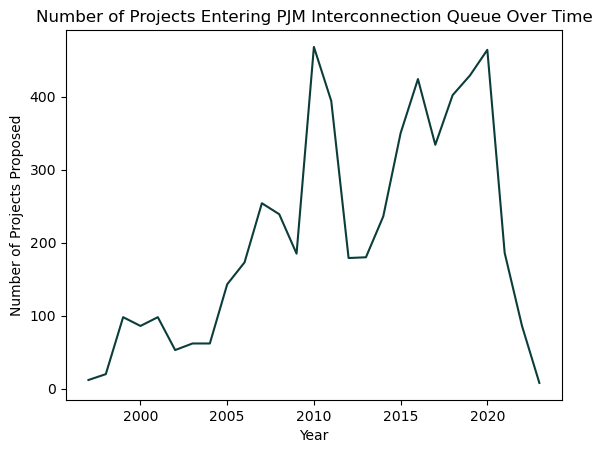

In [32]:
# Finding number of projects proposed over time
plt.plot(num_projs_basic.index, num_projs_basic['num_projects_proposed'],color='#0b3d3aff')
plt.xlabel('Year')
plt.ylabel('Number of Projects Proposed')
plt.title('Number of Projects Entering PJM Interconnection Queue Over Time');

#### Types of Energy

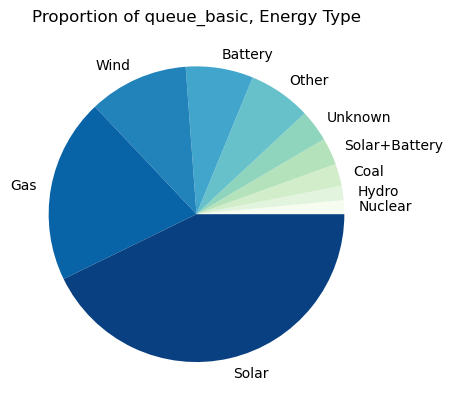

In [33]:
# queue_basic

# Finding proportions of different kinds of energy projects
type_counts = queue_basic.groupby('type_clean').count()['Project ID'].sort_values().tail(10)

# Plotting
cmap = plt.get_cmap('GnBu')
colors = cmap(np.linspace(0, 1, len(type_counts)))

plt.pie(type_counts, labels=type_counts.index, colors=colors)

plt.title('Proportion of queue_basic, Energy Type');

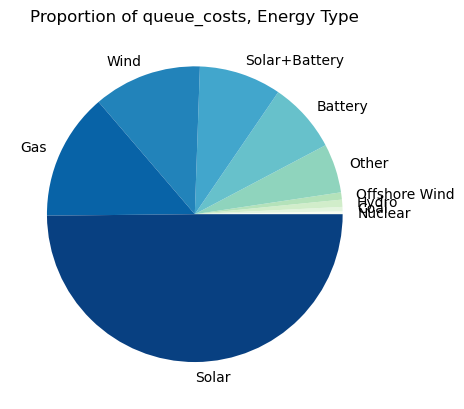

In [34]:
# queue_costs

# Finding proportions of different kinds of energy projects
type_counts = queue_costs.groupby('type_clean').count()['Project ID'].sort_values().tail(10)

# Plotting
cmap = plt.get_cmap('GnBu')
colors = cmap(np.linspace(0, 1, len(type_counts)))

plt.pie(type_counts, labels=type_counts.index, colors=colors)

plt.title('Proportion of queue_costs, Energy Type');

#### IA Status Depending on Year Proposed

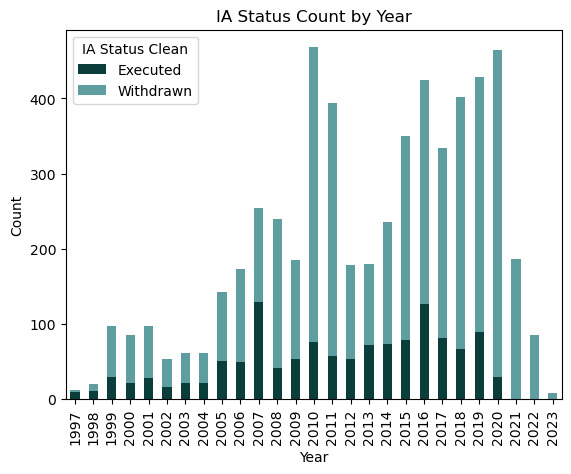

In [35]:
# queue_basic
data = queue_basic.groupby(['q_year', 'IA_Status_Clean']).size().unstack(fill_value=0)
data.index = data.index.astype(int)
colors = ['#0b3d3aff', '#5F9EA0']


# Plotting
data.plot(kind='bar', stacked=True, color=colors)
plt.title('IA Status Count by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='IA Status Clean')
plt.show()

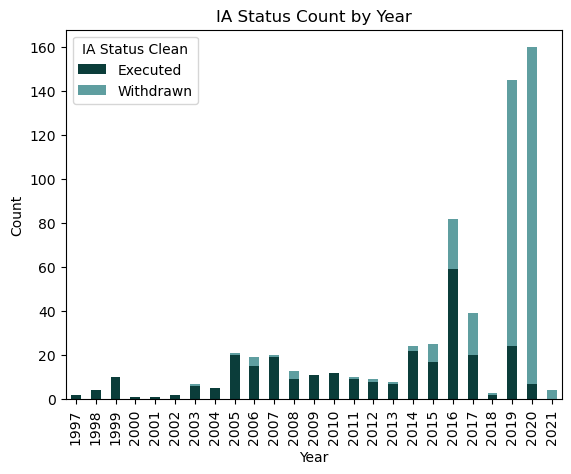

In [36]:
# queue_costs

data = queue_costs.groupby(['q_year', 'IA_Status_Clean']).size().unstack(fill_value=0)
data.index = data.index.astype(int)
colors = ['#0b3d3aff', '#5F9EA0']


# Plotting
data.plot(kind='bar', stacked=True, color=colors)
plt.title('IA Status Count by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='IA Status Clean')
plt.show()

#### Analyzing costs over different types of energy

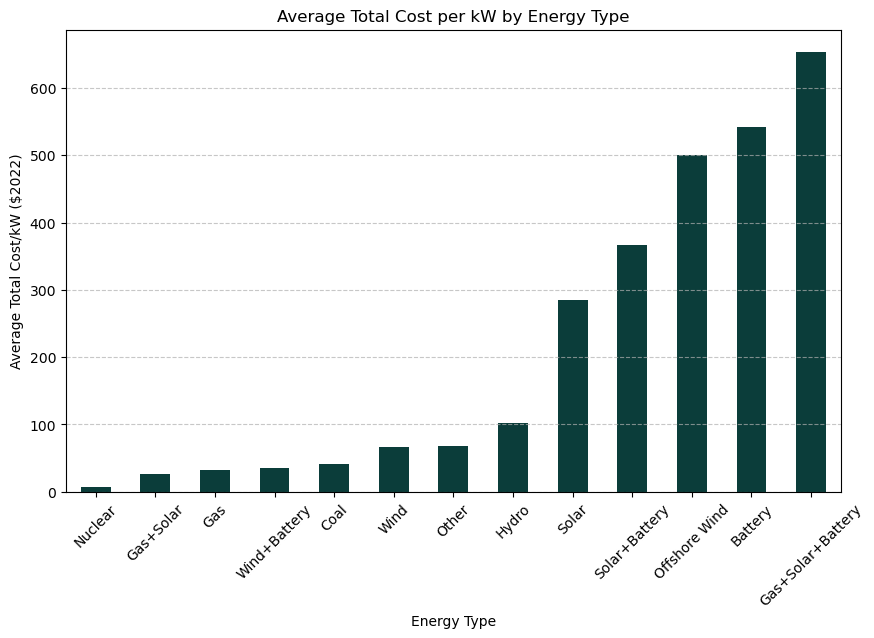

In [37]:
average_costs = queue_costs.groupby('type_clean')['$2022 Total Cost/kW'].mean()

# Sort the costs for better visualization, from lowest to highest
average_costs_sorted = average_costs.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
average_costs_sorted.plot(kind='bar', color='#0b3d3aff')  # Using the suggested color
plt.title('Average Total Cost per kW by Energy Type')
plt.xlabel('Energy Type')
plt.ylabel('Average Total Cost/kW ($2022)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()

## 5. Logistic Regression Grid Search Cross Validation

In [2]:
# Loading the dataframes back in
queue_basic_features = pd.read_csv('/home/jovyan/THESIS/dataframes/final_dataframes/queue_basic_features.csv')
queue_costs_features = pd.read_csv('/home/jovyan/THESIS/dataframes/final_dataframes/queue_costs_features.csv')

#### queue_basic

In [3]:
# X value
queue_basic_X = queue_basic_features.drop(columns={'IA_Status_Clean_Executed','IA_Status_Clean_Withdrawn'})

# Y value
queue_basic_y = queue_basic_features['IA_Status_Clean_Executed']

# Train-test split
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(queue_basic_X, queue_basic_y, test_size=0.2)

In [ ]:
# Initializing the Grid Search
# Defining a pipeline combining a standard scaler with logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(fit_intercept=True, max_iter=10000, solver='liblinear'))
])

# Defining the parameter grid
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Initialize the grid search
grid_search_basic = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search_basic.fit(X_train_basic, y_train_basic)

print("Best parameters:", grid_search_basic.best_params_)
print("Best cross-validation accuracy:", grid_search_basic.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Initializing the Random Search--Grid Search is too computationally intensive for Elastic Net
# Need to further split the data because this is too computationally intensive otherwise
X_train_basic_en, X_test_basic_en, y_train_basic_en, y_test_basic_en = train_test_split(X_train_basic, y_train_basic, test_size=0.2)

# Defining a pipeline combining a standard scaler with logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet',fit_intercept=True, max_iter=10000, solver='saga'))
])

# Defining the parameter grid
# Defining the parameter distributions
param_distributions = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# Initialize the randomized search
random_search_en_basic = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the randomized search to the data
random_search_en_basic.fit(X_train_basic_en, y_train_basic_en)

print("Best parameters:", random_search_en_basic.best_params_)
print("Best cross-validation accuracy:", random_search_en_basic.best_score_)

#### queue_costs

In [4]:
# X value
queue_costs_X = queue_costs_features.drop(columns={'IA_Status_Clean_Executed','IA_Status_Clean_Withdrawn'})

# Y value
queue_costs_y = queue_costs_features['IA_Status_Clean_Executed']

# Train-test split
X_train_costs, X_test_costs, y_train_costs, y_test_costs = train_test_split(queue_costs_X, queue_costs_y, test_size=0.15)

In [ ]:
# Initializing the Grid Search
# Defining a pipeline combining a standard scaler with logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(fit_intercept=True, max_iter=10000, solver='liblinear'))
])

# Defining the parameter grid
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Initialize the grid search
grid_search_costs = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search_costs.fit(X_train_costs, y_train_costs)

print("Best parameters:", grid_search_costs.best_params_)
print("Best cross-validation accuracy:", grid_search_costs.best_score_)

In [ ]:
# Initializing the Random Search--Grid Search is too computationally intensive for Elastic Net
# Defining a pipeline combining a standard scaler with logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet',fit_intercept=True, max_iter=10000, solver='saga'))
])

# Defining the parameter grid
# Defining the parameter distributions
param_distributions = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# Initialize the randomized search
random_search_en_costs = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the randomized search to the data
random_search_en_costs.fit(X_train_costs, y_train_costs)

print("Best parameters:", random_search_en_costs.best_params_)
print("Best cross-validation accuracy:", random_search_en_costs.best_score_)

## 6. Decision Tree Grid Search Cross Validation

#### queue_basic

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the classifier
dt_basic = DecisionTreeClassifier()

# Configure GridSearchCV
grid_search_basic_dt = GridSearchCV(estimator=dt_basic, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search_basic_dt.fit(X_train_basic, y_train_basic)

# Best parameters and best score
print("Best parameters found: ", grid_search_basic_dt.best_params_)
print("Best cross-validation score: {}".format(grid_search_basic_dt.best_score_))

#### queue_costs

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the classifier
dt_costs = DecisionTreeClassifier()

# Configure GridSearchCV
grid_search_costs_dt = GridSearchCV(estimator=dt_costs, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search_costs_dt.fit(X_train_costs, y_train_costs)

# Best parameters and best score
print("Best parameters found: ", grid_search_costs_dt.best_params_)
print("Best cross-validation score: {}".format(grid_search_costs_dt.best_score_))

## 7. Testing Optimal Models

#### queue_basic

In [7]:
# Test score of LR with standard regularization

# Best parameters: 'logreg__C': 0.1, 'logreg__penalty': 'l1'
best_lr_basic = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=0.1, penalty='l1', fit_intercept=True, max_iter=10000, solver='liblinear'))
])

# Fit the model 
best_lr_basic.fit(X_train_basic, y_train_basic)

# Generating predictions
y_pred_basic_lr = best_lr_basic.predict(X_test_basic)

score_basic_lr = best_lr_basic.score(X_test_basic, y_test_basic)

# Printing accuracy & confusion matrix
print(confusion_matrix(y_test_basic, y_pred_basic_lr))
print(score_basic_lr)

[[815  48]
 [187  75]]
0.7911111111111111


In [8]:
# Test score of LR with elastic net regularization

# Best parameters example: 'logreg__l1_ratio': 1, 'logreg__C': 10
best_lr_elasticnet = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=10, penalty='elasticnet', l1_ratio=1, fit_intercept=True, max_iter=10000, solver='saga'))
])

# Fit the model 
best_lr_elasticnet.fit(X_train_basic, y_train_basic)

# Generating predictions
y_pred_elasticnet = best_lr_elasticnet.predict(X_test_basic)

score_elasticnet = best_lr_elasticnet.score(X_test_basic, y_test_basic)

# Printing accuracy & confusion matrix
print(confusion_matrix(y_test_basic, y_pred_elasticnet))
print(score_elasticnet)

[[797  66]
 [175  87]]
0.7857777777777778


In [10]:
# Test score of decision tree classifier

# Best parameters: 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2
best_dt_basic = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=2)

# Fit the model 
best_dt_basic.fit(X_train_basic, y_train_basic)

# Generating predictions
y_pred_basic_dt = best_dt_basic.predict(X_test_basic)

score_basic_dt = best_dt_basic.score(X_test_basic, y_test_basic)

# Printing accuracy & confusion matrix

print(confusion_matrix(y_test_basic, y_pred_basic_dt))
print(score_basic_dt)

[[805  67]
 [152 101]]
0.8053333333333333


#### queue_costs

In [13]:
# Test score of LR with standard regularization

# Best parameters: 'logreg__C': 0.1, 'logreg__penalty': 'l1'
best_lr_costs = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=0.1, penalty='l1', fit_intercept=True, max_iter=10000, solver='liblinear'))
])

# Fit the model 
best_lr_costs.fit(X_train_costs, y_train_costs)

# Generating predictions
y_pred_costs_lr = best_lr_costs.predict(X_test_costs)

score_costs_lr = best_lr_costs.score(X_test_costs, y_test_costs)

# Printing accuracy & confusion matrix
print(confusion_matrix(y_test_costs, y_pred_costs_lr))
print(score_costs_lr)

[[43 10]
 [ 6 37]]
0.8333333333333334


In [14]:
# Test score of LR with elastic net regularization

# Best parameters example: 'logreg__l1_ratio': 0.5, 'logreg__C': 1
best_lr_elasticnet = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=10, penalty='elasticnet', l1_ratio=1, fit_intercept=True, max_iter=10000, solver='saga'))
])

# Fit the model 
best_lr_elasticnet.fit(X_train_costs, y_train_costs)

# Generating predictions
y_pred_elasticnet = best_lr_elasticnet.predict(X_test_costs)

score_elasticnet = best_lr_elasticnet.score(X_test_costs, y_test_costs)

# Printing accuracy & confusion matrix
print(confusion_matrix(y_test_costs, y_pred_elasticnet))
print(score_elasticnet)

[[43 10]
 [ 8 35]]
0.8125


In [9]:
# Test score of decision tree classifier

# Best parameters: 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5
best_dt_costs = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=5)

# Fit the model 
best_dt_costs.fit(X_train_costs, y_train_costs)

# Generating predictions
y_pred_costs_dt = best_dt_costs.predict(X_test_costs)

score_costs_dt = best_dt_costs.score(X_test_costs, y_test_costs)

# Printing accuracy & confusion matrix

print(confusion_matrix(y_test_costs, y_pred_costs_dt))
print(score_costs_dt)

[[54  7]
 [ 5 30]]
0.875


## 8. Feature Importances

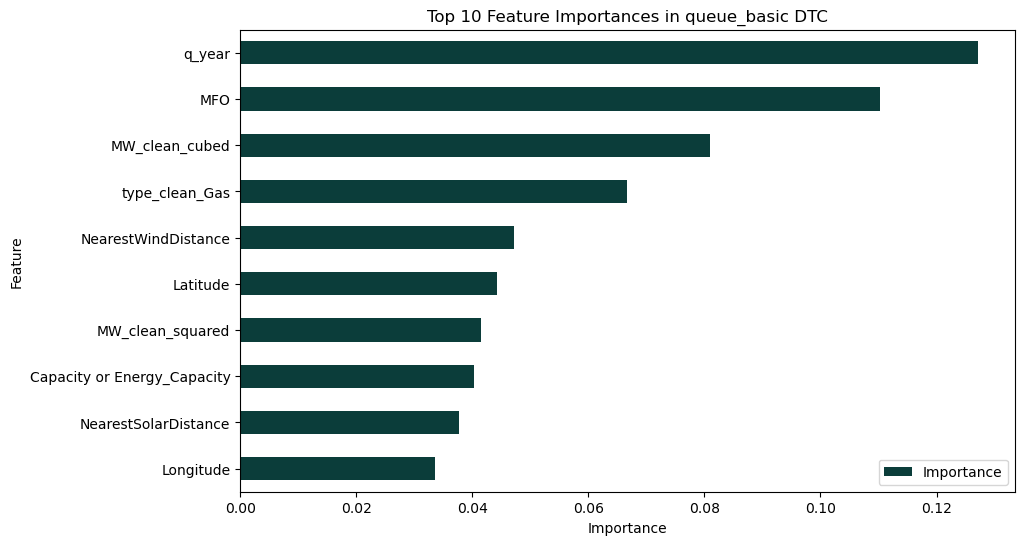

In [12]:
# queue_basic
feature_importances = best_dt_basic.feature_importances_

feature_importance = pd.DataFrame({'Feature': queue_basic_X.columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values('Importance', ascending=True).tail(10)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6),color='#0b3d3aff')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in queue_basic DTC')
plt.show()

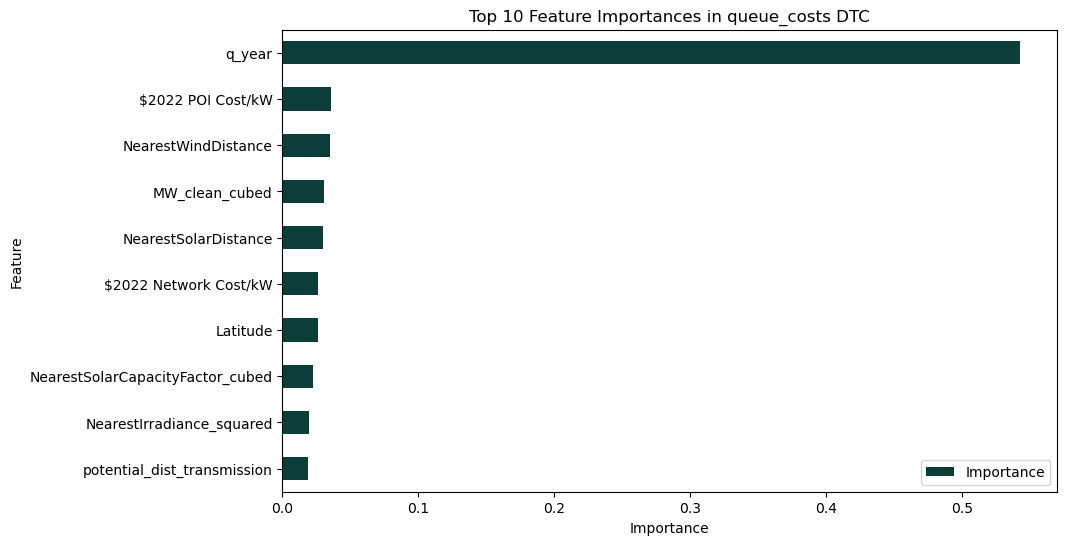

In [13]:
# queue_costs
feature_importances = best_dt_costs.feature_importances_

feature_importance = pd.DataFrame({'Feature': queue_costs_X.columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values('Importance', ascending=True).tail(10)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6),color='#0b3d3aff')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in queue_costs DTC')
plt.show()

## 9. Testing the Model on Renewables Only

In [14]:
# queue_basic

# Defining renewable as any project with a wind, solar, or storage component
# Finding only renewables project in the test set
non_renewable_basic = ['type_clean_Coal','type_clean_Gas','type_clean_Hydro','type_clean_Nuclear','type_clean_Other']


# Filtering basic X_test for renewables only: rows where all specified non-renewable columns are 0
# Now inverting the condition to get rows with all zeros in non_renewable columns
renewables_only_mask = ~X_test_basic[non_renewable_basic].any(axis=1)

# Apply this mask to filter X_test_4 and y_test_4
X_test_basic_renewables_only = X_test_basic[renewables_only_mask]
y_test_basic_renewables_only = y_test_basic[renewables_only_mask]

# Testing model accuracy on these test sets
y_renewable_pred_basic = best_dt_basic.predict(X_test_basic_renewables_only)

print(confusion_matrix(y_test_basic_renewables_only, y_renewable_pred_basic))
accuracy_score(y_test_basic_renewables_only, y_renewable_pred_basic)

[[620  25]
 [110  13]]


0.82421875

In [15]:
# queue_costs

# Defining renewable as any project with a wind, solar, or storage component
# Finding only renewables project in the test set
non_renewable_costs = ['type_clean_Coal','type_clean_Gas','type_clean_Hydro','type_clean_Nuclear','type_clean_Other']


# Filtering X_test_4 for renewables only: rows where all specified non-renewable columns are 0
# Now inverting the condition to get rows with all zeros in non_renewable columns
renewables_only_mask = ~X_test_costs[non_renewable_costs].any(axis=1)

# Apply this mask to filter X_test_4 and y_test_4
X_test_costs_renewables_only = X_test_costs[renewables_only_mask]
y_test_costs_renewables_only = y_test_costs[renewables_only_mask]

# Testing model accuracy on these test sets
y_renewable_pred_costs = best_dt_costs.predict(X_test_costs_renewables_only)

print(confusion_matrix(y_test_costs_renewables_only, y_renewable_pred_costs))
accuracy_score(y_test_costs_renewables_only, y_renewable_pred_costs)

[[52  6]
 [ 4 20]]


0.8780487804878049

## 10. Testing Accuracy w/o Temporal Variables

In [16]:
# Testing queue_basic

# Test score of decision tree classifier

# Best parameters: 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2
best_dt_basic_no = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=2)

# Deleting temporal variables
X_train_basic_no = X_train_basic.drop(columns={'q_year','num_projects_proposed'})
X_test_basic_no = X_test_basic.drop(columns={'q_year','num_projects_proposed'})

# Fit the model 
best_dt_basic_no.fit(X_train_basic_no, y_train_basic)

# Generating predictions
y_pred_basic_dt = best_dt_basic_no.predict(X_test_basic_no)

score_basic_dt = best_dt_basic_no.score(X_test_basic_no, y_test_basic)

# Printing accuracy & confusion matrix

print(confusion_matrix(y_test_basic, y_pred_basic_dt))
print(score_basic_dt)

[[827  45]
 [161  92]]
0.8168888888888889


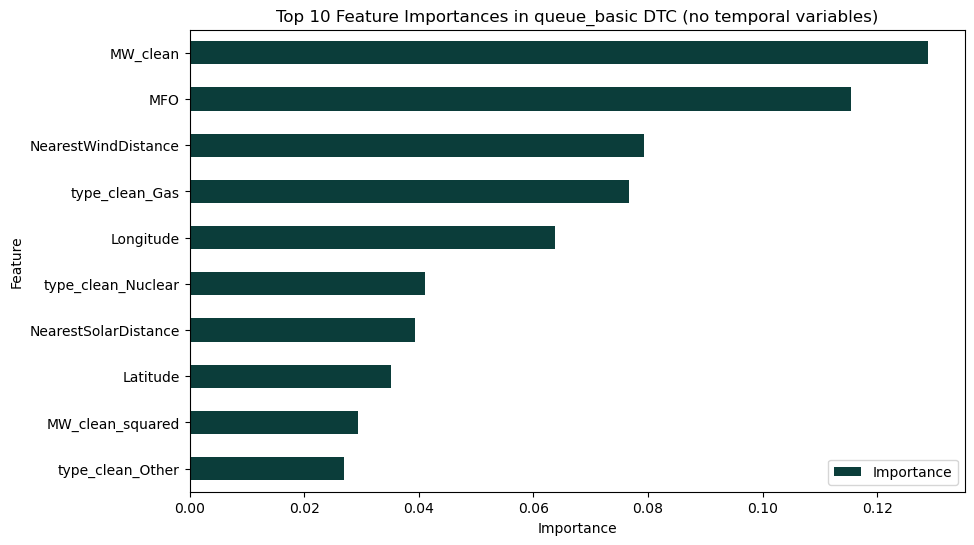

In [17]:
# queue_basic
feature_importances = best_dt_basic_no.feature_importances_

queue_basic_X_no = queue_basic_X.drop(columns={'q_year','num_projects_proposed'})

feature_importance = pd.DataFrame({'Feature': queue_basic_X_no.columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values('Importance', ascending=True).tail(10)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6),color='#0b3d3aff')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in queue_basic DTC (no temporal variables)')
plt.show()

In [18]:
# Testing queue_costs, due to its heavy reliance on temporal features, without q_year & num_projects_proposed

# Test score of decision tree classifier

# Best parameters: 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5
best_dt_costs_no = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=5)

# get rid of q_year
X_train_costs_no = X_train_costs.drop(columns={'q_year','num_projects_proposed'})
X_test_costs_no = X_test_costs.drop(columns={'q_year','num_projects_proposed'})

# Fit the model 
best_dt_costs_no.fit(X_train_costs_no, y_train_costs)

# Generating predictions
y_pred_costs_dt = best_dt_costs_no.predict(X_test_costs_no)

score_costs_dt = best_dt_costs_no.score(X_test_costs_no, y_test_costs)

# Printing accuracy & confusion matrix

print(confusion_matrix(y_test_costs, y_pred_costs_dt))
print(score_costs_dt)

[[52  9]
 [ 4 31]]
0.8645833333333334


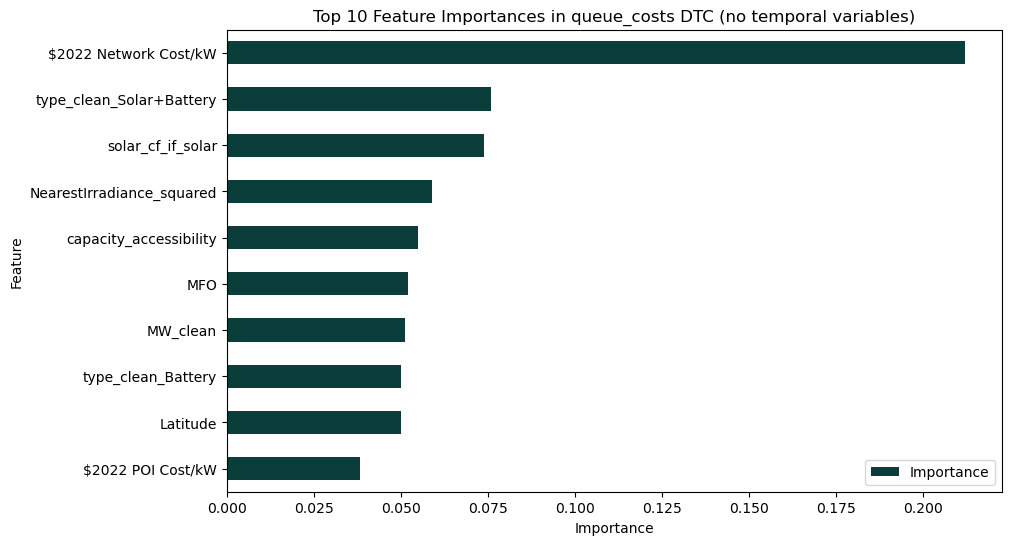

In [19]:
# queue_costs
feature_importances = best_dt_costs_no.feature_importances_

queue_costs_X_no = queue_costs_X.drop(columns={'q_year','num_projects_proposed'})

feature_importance = pd.DataFrame({'Feature': queue_costs_X_no.columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values('Importance', ascending=True).tail(10)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6),color='#0b3d3aff')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in queue_costs DTC (no temporal variables)')
plt.show()